In [2]:
import pandas as pd
import os
import pyodbc
import numpy as np
import re
import shutil
import matplotlib.pyplot as plt

In [6]:
sqlgdncli = pyodbc.connect("DRIVER={SQL Server};SERVER=SQLGDNCLI;DATABASE=WORKSPACE;Trusted_Connection=yes")

In [8]:
# Função para ler todos os arquivos

def ReadFiles(path, name_file):
    
    file = f'{path}{name_file}'

    names = [
        'CPF',
        'NOME',
        'NASC',
        'NOME_MAE',
        'SEXO',
        'SIGNO',
        'RENDA',
        'ESTADOCIVIL',
        'CBO',
        'DESCRICAO_CBO',
        'ESCOLARIDADE',
        'DESCRICAO_ESCOLARIDADE',
        'TIPO',
        'TITULO',
        'LOGRADOURO',
        'NUMERO',
        'COMPLEMENTO',
        'BAIRRO',
        'CIDADE',
        'UF',
        'CEP',
        'DDD1',
        'FONE1',
        'TIPO1',
        'DDD2',
        'FONE2',
        'TIPO2',
        'DDD3',
        'FONE3',
        'TIPO3',
        'DDD4',
        'FONE4',
        'TIPO4',
        'DDD5',
        'FONE5',
        'TIPO5',
        'DDD6',
        'FONE6',
        'TIPO6',
        'DDD7',
        'FONE7',
        'TIPO7',
        'DDD8',
        'FONE8',
        'TIPO8',
        'EMAIL_1',
        'EMAIL_2',
        'EMAIL_3',
    ]

    # Necessario trocar o separador, pois existem arquivos com separadores diferentes
    df = pd.read_csv(file, sep=';', names = names, header=None, skiprows = 1, index_col = False, encoding='ISO-8859-1')

    # Substituir NaN por 'Desconhecido'
    df['ESTADOCIVIL'].fillna('Desconhecido', inplace=True)

    # Utilizar expressão regular para encontrar o ano
    padrao = r'\\(\d{4})\\'
    correspondencia = re.search(padrao, path)
    
    ano = correspondencia.group(1)
        
    df['CAMINHO'] = file
    df['ARQUIVO'] = name_file
    df['ANO'] = ano

    return df

In [ ]:
# Concatena todos os arquivos de diferentes pastas em um DF (Arquivos com separador "|")

path_geral = 'I:\\Crescimento\\Temporário\\Rheydne\\Python\LeituraArquivosTelefone\\Arquivos\\'
nome_pastas = os.listdir(path_geral)
var = 0

for i in nome_pastas:
    path = f'{path_geral}{i}\\'

    # Lista com o nome de cada arquivo do Path
    name_file = os.listdir(path)

    # estrutura para concatenar cada arquivo em um DF unico
    for i, y in enumerate(name_file):

        df = ReadFiles(path, y)

        if(var == 0):
            df_final = df
            var = 1
        else:
            df_final = pd.concat([df_final, df])

In [ ]:
# Arquivos com separador ";"

path = 'I:\\Crescimento\\Temporário\\Rheydne\\Python\\LeituraArquivosTelefone\\Formatos diferentes\\2023\\'
nome_pastas = os.listdir(path)

# estrutura para concatenar cada arquivo em um DF unico
for i, y in enumerate(nome_pastas):

    df = ReadFiles(path, y)

    df_final = pd.concat([df_final, df])

In [ ]:
# Remove da pasta os arquivos com formatos diferentes

avaliar = df_final[df_final['NOME'].isnull()]
avaliar = avaliar['ARQUIVO'].unique()

caminho_origem = 'I:\\Crescimento\\Temporário\\Rheydne\\Python\LeituraArquivosTelefone\\Arquivos\\2023\\'
caminho_destino = 'I:\\Crescimento\\Temporário\\Rheydne\\Python\\LeituraArquivosTelefone\\'

for i in avaliar:
    caminho = f'{caminho_origem}{i}'
    shutil.move(caminho, caminho_destino)

In [13]:
# Insert Dataframe into SQL Server:

cursor = sqlgdncli.cursor()
df_final = df_final.astype(str)
cont = 0

for index, row in df_final.iterrows():

        cont = cont + 1
        cursor.execute('''
                INSERT INTO TE_DADOS_ENRIQ_TELEFONES_ALERTAKI 
                        (CPF,NOME,NASC,NOME_MAE,SEXO,SIGNO,RENDA,ESTADOCIVIL,CBO,DESCRICAO_CBO,ESCOLARIDADE,DESCRICAO_ESCOLARIDADE,
                        TIPO,TITULO,LOGRADOURO,NUMERO,COMPLEMENTO,BAIRRO,CIDADE,UF,CEP,DDD1,FONE1,TIPO1,DDD2,FONE2,TIPO2,DDD3,FONE3,
                        TIPO3,DDD4,FONE4,TIPO4,DDD5,FONE5,TIPO5,DDD6,FONE6,TIPO6,DDD7,FONE7,TIPO7,DDD8,FONE8,TIPO8,EMAIL_1,EMAIL_2,
                        EMAIL_3,CAMINHO,ARQUIVO,ANO) 
                VALUES 
                        (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''',
                row.CPF, row.NOME, row.NASC, row.NOME_MAE, row.SEXO, row.SIGNO, row.RENDA, row.ESTADOCIVIL, row.CBO, row.DESCRICAO_CBO,
                row.ESCOLARIDADE, row.DESCRICAO_ESCOLARIDADE, row.TIPO, row.TITULO, row.LOGRADOURO, row.NUMERO, row.COMPLEMENTO, row.BAIRRO,
                row.CIDADE, row.UF, row.CEP, row.DDD1, row.FONE1, row.TIPO1, row.DDD2, row.FONE2, row.TIPO2, row.DDD3, row.FONE3, row.TIPO3,
                row.DDD4, row.FONE4, row.TIPO4, row.DDD5, row.FONE5, row.TIPO5, row.DDD6, row.FONE6, row.TIPO6, row.DDD7, row.FONE7, row.TIPO7,
                row.DDD8, row.FONE8, row.TIPO8, row.EMAIL_1, row.EMAIL_2, row.EMAIL_3, row.CAMINHO, row.ARQUIVO, row.ANO
                )
        
        if cont > 10000:
                sqlgdncli.commit()
                cont = 0

cursor.close()

In [ ]:
#df_final.dropna(subset=['NOME'], inplace=True)
#df_final[df_final['NOME'].isnull()]
#df_final

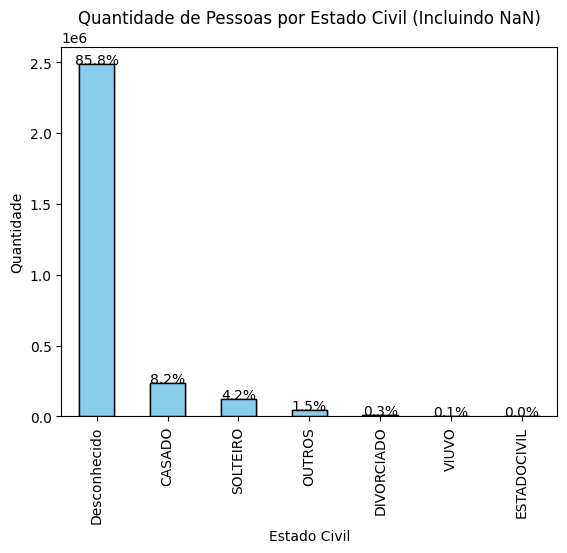

In [25]:
# Avaliação Estado Civil

# Contagem de pessoas por estado civil
contagem_estado_civil = df_final['ESTADOCIVIL'].value_counts()

# Calcular porcentagens
porcentagens = (contagem_estado_civil / contagem_estado_civil.sum()) * 100

# Gráfico de barras com porcentagens internas
ax = contagem_estado_civil.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Quantidade de Pessoas por Estado Civil (Incluindo NaN)')
plt.xlabel('Estado Civil')
plt.ylabel('Quantidade')

# Adicionar porcentagens internas nas barras
for i, v in enumerate(contagem_estado_civil):
    ax.text(i, v + 0.1, f'{porcentagens.iloc[i]:.1f}%', ha='center')

plt.show()






In [27]:
cursor = sqlgdncli.cursor()

query = '''
        SELECT DISTINCT A.NUM_PES, B.ESTADOCIVIL
        FROM [MERCANTIL\\b042304].[TE_ENRIQUECIMENTO_ESTADO_CIVIL] A
        INNER JOIN (
            SELECT DISTINCT NUM_PES, ESTADOCIVIL
            FROM [MERCANTIL\\b042304].[TI_BENEF_FINAL]
            WHERE ESTADOCIVIL IN ('CASADO')

            UNION 

            SELECT DISTINCT NUM_PES, ESTADOCIVIL
            FROM [MERCANTIL\\b042304].[TI_BENEF_FINAL]
            WHERE ESTADOCIVIL IN ('UNIAO ESTAVEL')
            AND NUM_PES NOT IN (
                SELECT NUM_PES
                FROM [MERCANTIL\\b042304].[TI_BENEF_FINAL]
                WHERE ESTADOCIVIL IN ('CASADO')
                )

            UNION

            SELECT DISTINCT B.NUM_PES, A.ESTADOCIVIL
            FROM TE_DADOS_ENRIQ_TELEFONES_ALERTAKI A
            INNER JOIN [SHARESPACE].[MERCANTIL\Y041326].[TC_PERFIL_CLIENTE] B
            ON A.CPF = B.CPF
            WHERE ESTADOCIVIL = 'CASADO'
            AND NUM_PES NOT IN (
                SELECT DISTINCT NUM_PES
                FROM [MERCANTIL\\b042304].[TI_BENEF_FINAL]
                WHERE ESTADOCIVIL IN ('UNIAO ESTAVEL', 'CASADO')
                )
            ) B
        ON A.NUM_PES = B.NUM_PES
'''

# Executar a consulta e ler o resultado em um DataFrame
df_resultado = pd.read_sql_query(query, sqlgdncli)

df_resultado['NUM_PES'] = df_resultado['NUM_PES'].astype(int)

# Salvar o DataFrame em um arquivo CSV
df_resultado.to_csv('enriquecimento_estadocivil.csv', index=False, sep=';')

# Fechar a conexão
cursor.close()


C:\Users\B042304\AppData\Local\Temp\ipykernel_988\965546932.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultado = pd.read_sql_query(query, sqlgdncli)


In [28]:
print(len(df_resultado))
df_resultado['NUM_PES'].nunique()

22638


22638